<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Sampling_testcode%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 성능 예측 알고리즘 검증 실험 (2023.6.23)

## 준비

### library

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import json

### G Drive mount

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


### Initial Checker

In [3]:
class InitialChecker():
    def __init__(self, model, train, live, drop_cols, y):
        self.model = model
        self._Xtrain = train.drop(columns=drop_cols).values
        self._ytrain = train[y].values
        self.live = live
        self.drop_cols = drop_cols
        self.y = y


    def check_drift(self, drift_checkers):
        Xlive = self.live.drop(columns=self.drop_cols).values
        drift_value = np.array([dc(Xlive, self._Xtrain, self.model) for dc in drift_checkers])
        df_drift = {}
        for i, dc in enumerate(drift_checkers):
            df_drift["%s"%dc.__name__] = drift_value[i]
        return df_drift

### Multi-Variate Sampler

In [4]:
class MVSampler():
    def __init__(self, reference, inference, target_cols):
        """
        reference : pd.DataFrame. 모집단으로 사용될 set.(test를 넣으면 됨)
        inference : pd.DataFrame. 배경집단으로 사용된 inference set
        target_cols : array-like. 해당 column들에 대해서만 확률 계산
        """
        self._pdf = {}
        self._cnt = np.zeros(reference.shape[0])
        self.reference = reference.copy()
        del reference
        self.inference = inference.copy()
        del inference
        self.target_cols = target_cols

        bins = int(1+3.322*np.log10(self.inference.shape[0]))
        for col in self.target_cols:
            p, bin_edge = np.histogram(self.inference[col].values,
                                       bins=np.min([bins, len(self.inference[col].unique())]),
                                       density=True)
            self._pdf[col] = (p, bin_edge)

        for col in self.target_cols:
            bin_edge = self._pdf[col][1]
            b = (bin_edge[1:] + bin_edge[:-1])/2
            lcond = self.reference[col].values>=b.min()
            rcond = self.reference[col].values<=b.max()
            self._cnt += (lcond*rcond*1)

    def build(self, row_min = -1, outlier = 0):
        """
        row_min : int. sampling에 사용될 reference의 최소 row 갯수
        outlier : int. ref/inf 의 target_col 분포를 비교할 때, 고려하지 않을 column의 갯수
        모든 target_col이 ref/inf 분포가 겹치지 않을 수 있기 때문에 일정 row 갯수가 확보될 때 까지 증가
        """
        if row_min  < 0:
            row_min = int(self.inference.shape[0] * 0.1)

        nsize = len(np.where(self._cnt>=len(self.target_cols)-outlier)[0])
        while (nsize <= row_min) and (outlier <= len(self.target_cols)):
            outlier += 1
            nsize = len(np.where(self._cnt>=len(self.target_cols)-outlier)[0])
        self._outlier = outlier

        self.likelihood = np.zeros(self.reference.shape[0])
        for i in range(self.reference.shape[0]):
            row_vector = self.reference.iloc[i, :]
            if self._cnt[i]>=len(self.target_cols)-outlier:
                p = np.array([self.interp_pdf(self._pdf[col], row_vector[col]) for col in self.target_cols])
                self.likelihood[i] = np.power(10, np.sum(np.log10(p[np.where(p!=0)[0]])))

    @staticmethod
    def interp_pdf(pdf, x):
        p, bin_edge = pdf
        b = (bin_edge[1:] + bin_edge[:-1])/2
        if x<=b.min() or x>=b.max():
            return 0
        f = interp1d(b, p, kind="linear")
        y = f(x)
        return y

    def sample(self, n=-1, seed=None, return_index=False):
        """
        n : int. sample의 크기
        return_index : bool. True일 경우 sample의 index를 array로 return, False일 경우 sample을 pd.DataFrame으로 return. 기본은 False
        return : pd.DataFrame / array-like
        """
        n = n if n>0 else self.inference.shape[0]//10
        prob = self.likelihood #np.power(10, self.log_likelihood)
        prob /= np.sum(prob)
        rng = np.random.default_rng(seed)
        idx = rng.choice(np.arange(0, self.reference.shape[0]), replace=True, p=prob, size=n)
        if return_index:
            return idx
        return self.reference.iloc[idx, :]

### Sample Analyzer

In [5]:
class SampleAnalyzer():
    def __init__(self, model, train, sample,drop_cols, y):
        """
        train : pd.DataFrame.
        drift_detectors : array-like. drift value계산을 위한 function point. ex)ks_drift_checker(ref, live, model)
        target_cols : array-like. 해당 column들에 대해서만 확률 계산
        drop_cols : array-like. X domain에서 제외해야할 column. ex) loan_data : [loan_paid, time]
        """
        self.model = model
        self._Xtrain = train.drop(columns = drop_cols).values
        self.sample = sample
        self.drop_cols = drop_cols
        self.y = y

    def check_drift(self, drift_checkers):
        drift_value = []
        for sample in self.sample:
            Xsmp = sample.drop(columns=self.drop_cols).values
            dvs = np.array([dc(Xsmp, self._Xtrain, self.model) for dc in drift_checkers])
            drift_value.append(dvs)
        drift_value= np.array(drift_value)

        df_drift = {}
        for i, dc in enumerate(drift_checkers):
            df_drift["%s"%dc.__name__] = drift_value[:, i]
        return df_drift

    def check_metric(self, metrics):
        df_metric = {}
        samples = [(sample.drop(columns=self.drop_cols).values, sample[self.y].values) for sample in self.sample]

        for metric in metrics:
            metric_name = metric.__name__
            df_metric[metric_name] = np.zeros(len(samples))
            for i, (Xsmp, ysmp) in enumerate(samples):
                df_metric[metric_name][i] = metric(self.model, Xsmp, ysmp)
        return df_metric

### Performance Estimator

In [6]:
def dist(slope, intercept, x, y):
    return abs(slope*x-y+intercept)/np.sqrt(slope**2+1)
def linear(x, a, b):
    return a*x+b
def chi2(slope, intercept, x, y):
    dobs = dist(slope, intercept, x, y)**2
    return np.sum(dobs)/ 2 / (len(x)-2)


class PerformanceEstimator():
    def __init__(self, drift, drift_smp, metric_smp):
        self.drift = drift
        self.drift_smp = drift_smp
        self.metric_smp = metric_smp

    def estimate(self, n = 5):
        drift_list = self.drift_smp.keys()
        metric_list = self.metric_smp.keys()
        if len(self.drift[list(self.drift.keys())[0]])<n:
            return self.metric_smp

        metric_est = {}
        for key, m in self.metric_smp.items():
            metric_est[key] = self.correction(metric= m, drift =self.drift, drift_smp = self.drift_smp)
        return metric_est

    @staticmethod
    def nlinearfit(x, y, th = 2):
        x = np.array(x) if isinstance(x, list) else x
        y = np.array(y) if isinstance(y, list) else y
        m = (y.max() - y.min()) / (x.min() - x.max())
        i = y.mean() - m * x.mean()
        d, c2 = dist(m, i, x, y), chi2(m, i, x, y)
        cnt = 0

        while c2>th and m>0 and cnt<len(x)-4:
            xn, yn = x[np.argsort(d)[:len(x)-cnt]], y[np.argsort(d)[:len(x)-cnt]]
            popt, _ = curve_fit(linear, xn, yn)
            m, i = popt[0], popt[1]
            c2 = chi2(m, i, xn, yn)
            cnt += 1
        c2 = chi2(m, i, x, y)
        return m, i, c2

    @staticmethod
    def correction(metric, drift, drift_smp):
        metric_cor = 0
        denominator = 0

        for k in drift_smp.keys():
            d, d_smp =  drift[k], drift_smp[k]
            dbar = d[-1] - np.min(d)
            dbar_smp = d_smp - np.min(d_smp)
            r1, beta, chi2 = PerformanceEstimator.nlinearfit(dbar_smp, metric, 1.6)
            metric_cor += (r1 * dbar + beta) / chi2
            denominator +=  (1/chi2)

        return metric_cor/denominator

### Metric & drift checker (Temporal)

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def accuracy(model, X, y):
    return accuracy_score(model.predict(X), y)*100

def f1(model, X, y):
    return f1_score(model.predict(X), y) *100

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def D3(reference, inference, model):
    y1 = np.zeros(reference.shape[0]).reshape(-1, 1)
    y2 = np.ones(inference.shape[0]).reshape(-1, 1)
    X = np.vstack((reference, inference))
    y = np.vstack((y1, y2))
    lr = LogisticRegression(solver="lbfgs", random_state=0, max_iter=5000).fit(X, y.ravel())
    return roc_auc_score(y, lr.predict_proba(X)[:, 1])

from scipy.stats import ks_2samp, entropy
def uncertainty(reference, inference, model):
    entropy_ref = entropy(model.predict_proba(reference), axis = -1)
    entropy_inf = entropy(model.predict_proba(inference), axis = -1)
    d, p = ks_2samp(entropy_ref, entropy_inf)
    return d

from scipy.linalg import sqrtm
def FID(reference, inference, model):
    act_ref, act_inf = [], []

    for i in range(reference.shape[0]):
        refr, infr = reference[i, :], inference[i, :]
        vmin, vmax = min(refr.min(), infr.min()), max(refr.max(), infr.max())
        bins = int(1+3.322*np.log10(max(len(refr), len(infr))))
        refh, _ = np.histogram(refr, range=(vmin, vmax), bins=bins)
        infh, _ = np.histogram(infr, range=(vmin, vmax), bins=bins)
        act_ref.append(refh)
        act_inf.append(infh)

    act_ref = np.array(act_ref)
    act_inf = np.array(act_inf)
    mu1, sigma1 = np.mean(act_ref, axis=0), np.cov(act_ref, rowvar=False)
    mu2, sigma2 = np.mean(act_inf, axis=0), np.cov(act_inf, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    mat_dot = sigma1.dot(sigma2)
    covmean = sqrtm(mat_dot)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### 검증용 함수

In [25]:
from tqdm import tqdm
from time import time

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,sample_count=100):

    drift_checkers = [D3, uncertainty, FID]
    metrics = [accuracy, f1]

    ### Define DB
    DB = {}
    for metric in metrics:
        DB[metric.__name__] = []
        DB[metric.__name__+"_smp"] = []
        DB[metric.__name__+"_est"] = []
    for dc in drift_checkers:
        DB[dc.__name__] = []
        DB[dc.__name__+"_smp"] = []
    DB["time"] = []

    t0 = time()

    for live in tqdm(live_set):
        tl = time()

        ### 1) Agent : live의 drift value 측정
        ic = InitialChecker(
            model = model,
            train = df_train,
            live = live,
            drop_cols= drop_cols,
            y = ylabel
            )
        drift0 = ic.check_drift(drift_checkers=drift_checkers)

        ### DB에 저장
        DB["time"].append(np.mean(live.index.values))
        for k, v in drift0.items():
            DB[k].append(v)


        ### 1-1)send <live> to Engine

        ### 2) Engine
        mvs = MVSampler(df_test, live, target_cols)
        mvs.build()
        sample = [mvs.sample(return_index=False) for _ in range(sample_count)]

        ### 2-1) send <sample> to Agent

        ### 3) Agent ###
        sa = SampleAnalyzer(
            model = model,
            train = df_train,
            sample = sample,
            drop_cols = drop_cols,
            y = ylabel
            )

        drift = sa.check_drift(drift_checkers = drift_checkers)
        metric = sa.check_metric(metrics = metrics)
        ### DB에 저장
        for k, v in drift.items():
            DB[k+"_smp"].append(np.mean(v))
        for k, v in metric.items():
            DB[k+"_smp"].append(np.mean(v))

        ### DB에서 load
        DB_drift = {k:DB[k] for k in drift.keys()}
        DB_drift_smp = {k:DB[k+"_smp"] for k in drift.keys()}
        DB_metric_smp = {k:DB[k+"_smp"] for k in metric.keys()}

        pe = PerformanceEstimator(
            drift = DB_drift,
            drift_smp = DB_drift_smp,
            metric_smp = DB_metric_smp)

        metric_est = pe.estimate(n = 5)
        for k, v in metric_est.items():
            if isinstance(v, list):
                DB[k+"_est"].append(v[-1])
            else:
                DB[k+"_est"].append(v)

        for m in metrics:
            DB[m.__name__].append(m(model, live.drop(columns=drop_cols).values, live[ylabel].values))

        #print("%d"%np.mean(live.index.values), " : " ,"%d [sec]"%(time()-tl))
    print("Total dT : %d : %d"%(divmod(time()-t0, 60)))


    color = ["b", "r" ,"k"]
    for (c, m) in zip(color, metrics):
        name = m.__name__

        plt.figure(figsize=main_figsize)
        plt.plot(DB["time"], DB[name], linewidth=1,label=name+'_ori', color=c)
        plt.plot(DB["time"], DB[name+"_smp"], linewidth=1,label=name+"_smp", color=c, linestyle=":")
        plt.plot(DB["time"], DB[name+"_est"], linewidth=1,label=name+"_est", color=c, linestyle="--")

        r2 = r2_score(DB[name],DB[name+"_est"])
        print(f'R2 for {name} : ', r2)

        plt.xlim(min(DB["time"]), max(DB["time"]))
        plt.grid(visible=True)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    return DB, metrics

## 검증 실험

### 준비 함수들...

In [9]:

import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import math

from torch.autograd import Variable
from argparse import Namespace
import warnings
warnings.filterwarnings("ignore")
import random
import os

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

main_figsize=(15,3)

def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [10]:

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [42]:
def MI_Drift_F1(model, X,y,train_size,test_size,bucket_size=200):

    MIS = {}
    DRF = {}
    F1S = []
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    step_size = int((X.shape[0]-(train_size+test_size))/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tmp_x = X[bk*bucket_size:bk*bucket_size+bucket_size]
        tmp_y = y[bk*bucket_size:bk*bucket_size+bucket_size]
        mi_scores = make_mi_scores(tmp_x,tmp_y , discrete_features="auto")
        ks = __ks_drift(X[0:train_size].values,
                        X[bk*bucket_size+(train_size+test_size):bk*bucket_size+bucket_size+(train_size+test_size)].values)
        predicted_y = model.predict(tmp_x)
        f1_ = f1_score(tmp_y,(predicted_y > 0.5).astype(float))
        F1S.append(f1_)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(F1S,linewidth=1,label='f1 score')
    plt.ylabel('F1 Score')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1)
    plt.show()

### Case #1 MI의 감소, Drift의 증가

In [39]:

data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

seed_everything()

y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(0,cor_,data_size)

seed_everything(100)

for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)

In [40]:

columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 400 step_size 95


100%|██████████| 95/95 [00:04<00:00, 23.65it/s]


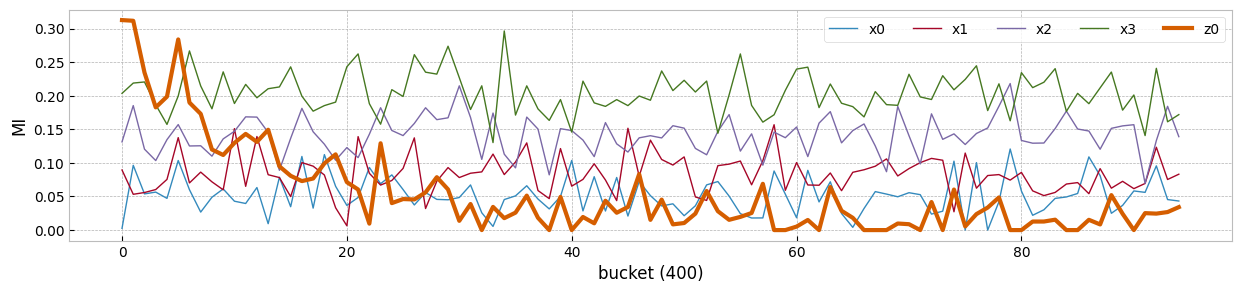

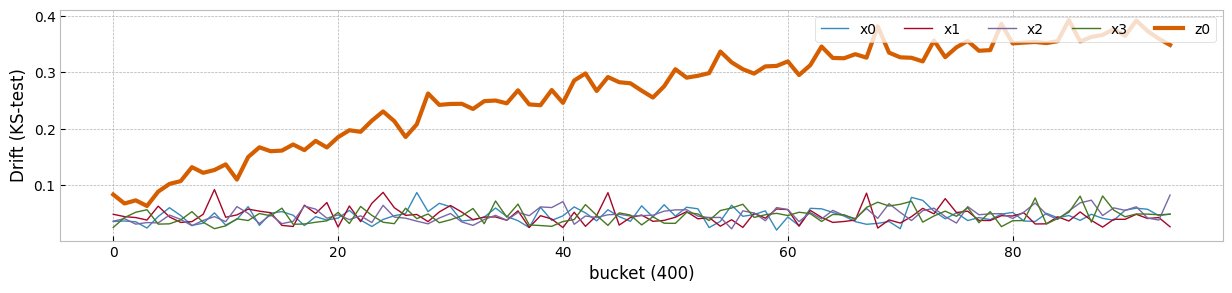

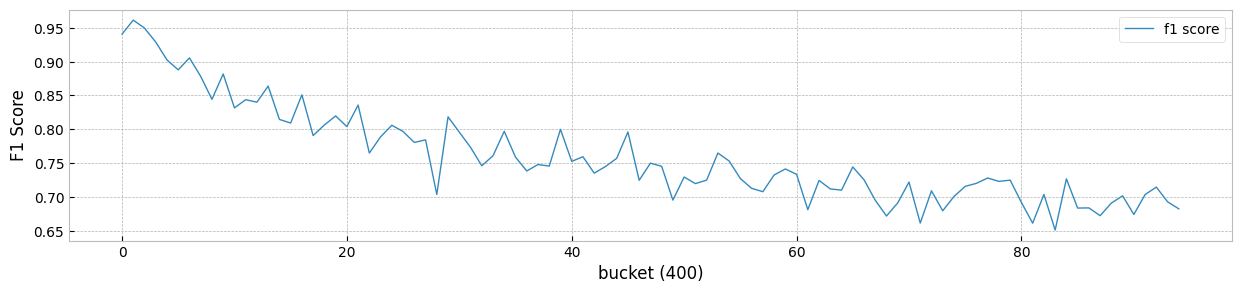

In [43]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

######################## Normalization ############################
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X[0:1800], y[0:1800])

MI_Drift_F1(model, X,y,1800,200,400)


#### 실험 #1
+ train:test = 1800:200

In [27]:
#model = model
X['Y'] = y

bucket_size=400

df_train = X[0:1800]
df_test = X[1800:2000]
ylabel = "Y"
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

In [28]:

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, y[0:1800])

In [29]:
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)

feature 5, test_f1 0.8685714285714285


100%|██████████| 95/95 [09:04<00:00,  5.73s/it]


Total dT : 9 : 4
R2 for accuracy :  -2.5687147269214265


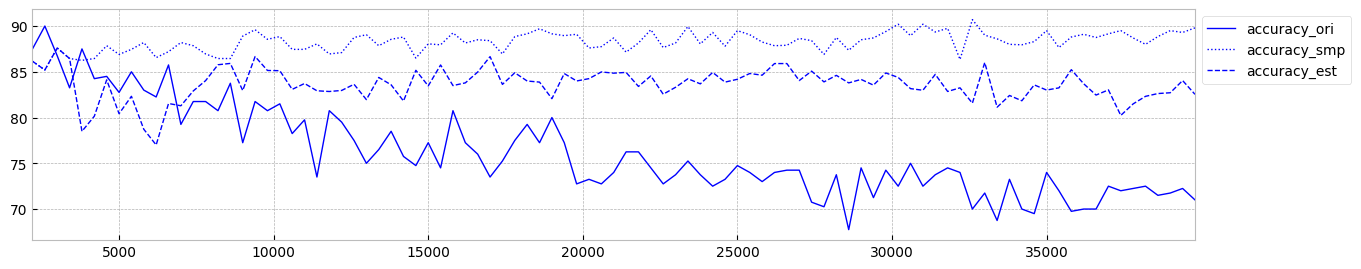

R2 for f1 :  -1.4087237679642342


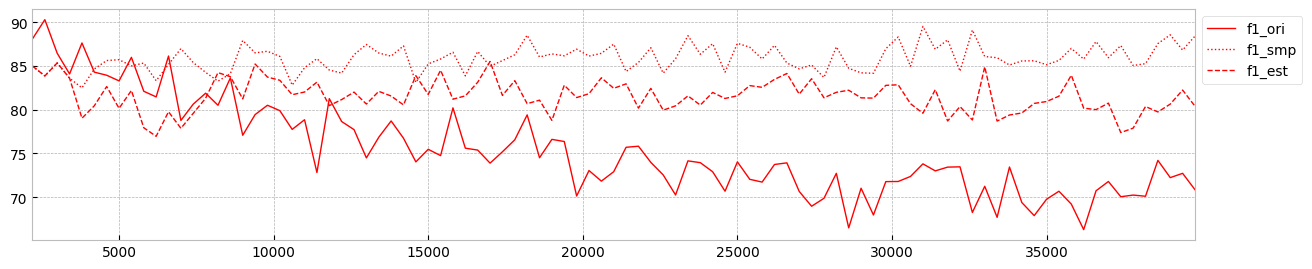

In [30]:
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,50)

#### 실험 #2
+ train:test = 2000:2000

In [31]:
#model = model
X['Y'] = y

bucket_size=400

df_train = X[0:2000]
df_test = X[2000:4000]
ylabel = "Y"
live_set = [X[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

feature 5, test_f1 0.8764705882352941


100%|██████████| 90/90 [12:52<00:00,  8.58s/it]


Total dT : 12 : 52
R2 for accuracy :  -1.339055077752957


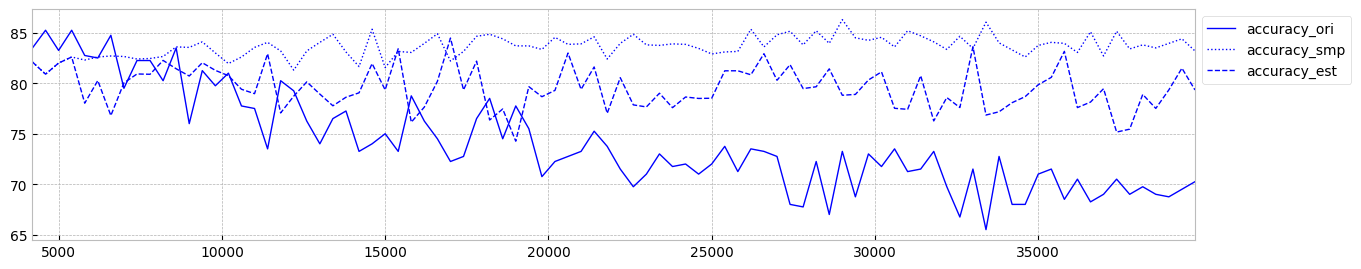

R2 for f1 :  -1.2077541104529597


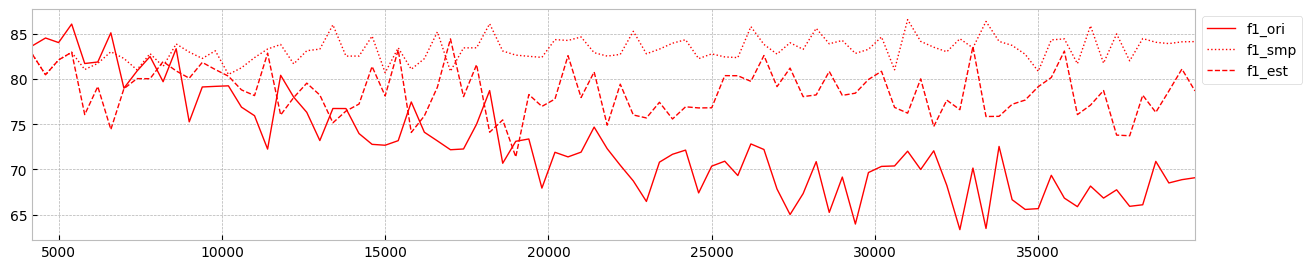

In [32]:
model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, y[0:2000])
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,50)

#### 실험 #3
+ train:test = 2000:2000 (random)

In [33]:
from sklearn.model_selection import train_test_split

#model = model
X['Y'] = y

bucket_size=400

df_train, df_test, y_train, y_test = train_test_split(X[0:4000], y[0:4000], test_size=0.5,random_state=777)
#df_train = X[0:2000]
#df_test = X[2000:4000]
ylabel = "Y"
live_set = [X[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

In [34]:
df_train

,x0,x1,x2,x3,z0,Y
2668,0.261852,0.382188,0.948918,2.657438,-1.363288,1
3718,0.407237,1.665092,1.244849,1.530161,0.920891,1
1277,-2.168911,-0.484068,-1.426376,0.271544,0.944408,0
2776,1.371100,-1.751179,0.863887,1.850505,1.552686,1
764,0.817581,1.738785,1.201055,0.190111,0.026198,1
...,...,...,...,...,...,...
3671,-0.001674,-0.119799,0.293550,1.686264,-0.499206,1
2982,0.246481,-0.627001,0.117306,-1.457659,-1.796106,0
3643,0.760341,0.101382,0.820141,0.656553,2.619890,1
2863,-1.669270,1.893181,0.099027,0.458586,-0.528401,1


feature 5, test_f1 0.8803970223325063


100%|██████████| 90/90 [12:18<00:00,  8.21s/it]


Total dT : 12 : 18
R2 for accuracy :  0.11745899709351693


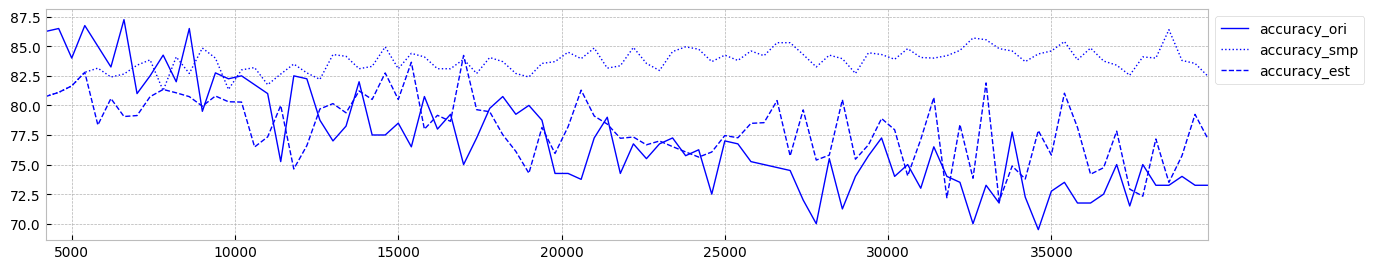

R2 for f1 :  0.2182346803370926


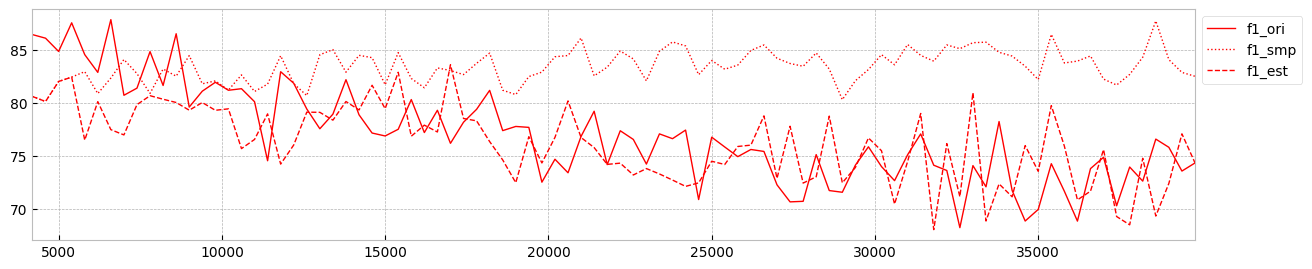

In [35]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols])
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,50)

#### 실험 #4
+ train:blank:test = 2000:2000:2000

In [36]:
#model = model
X['Y'] = y

bucket_size=400

df_train = X[0:2000]
df_test = X[4000:6000]
ylabel = "Y"
live_set = [X[i*bucket_size+6000:i*bucket_size+bucket_size+6000] for i in range(int(X[6000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

feature 5, test_f1 0.8318318318318318


100%|██████████| 85/85 [11:32<00:00,  8.15s/it]


Total dT : 11 : 32
R2 for accuracy :  0.09367528556857052


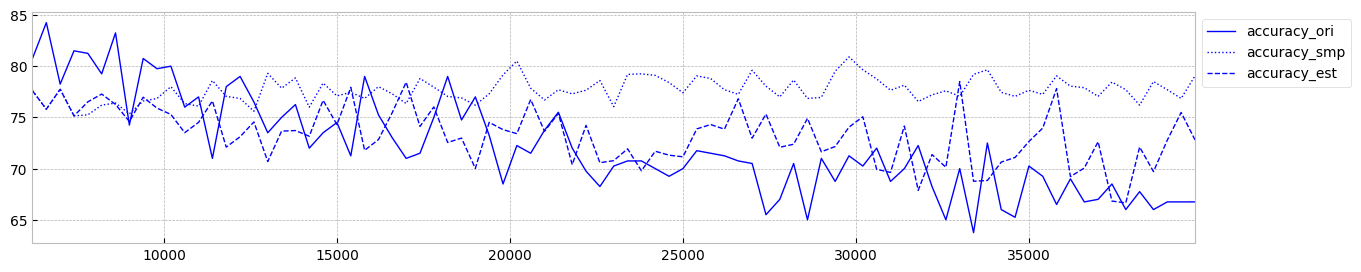

R2 for f1 :  0.016687877257148598


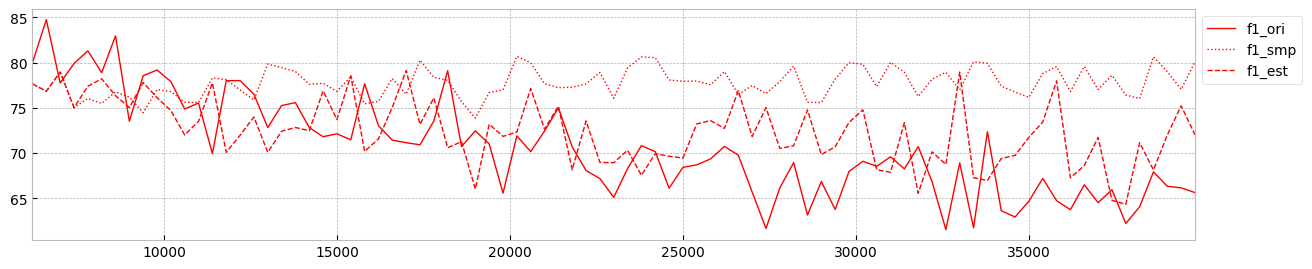

In [37]:
model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, y[0:2000])
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,50)

#### Case #1 결론
+ 2000:2000 + shuffling 한 것이 가장 좋음. shuffle 한 것이 더 좋은 결과는?
+ 역시, Test의 size가 어느 정도 확보 되어야 함. (기준은...??)
+ 2000:blank:2000 이 가장 좋을 줄 알았으나... 아님.
+ 초기, 예측 오차가 오히려 큰것으로 보임? -> 개선 point ?
+ Test의 크기를 확보하기 위해, 생성모델을 활용해 보는 것은? / Ground Truth 의 신뢰성 확보가 안되서, 안될 듯..

### Case #2 MI의 증감(상대적), Drift의 고정

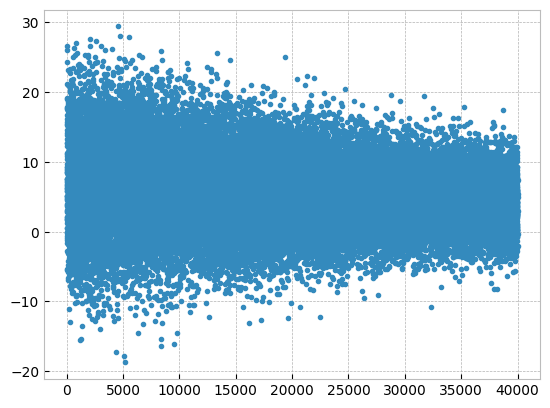

In [44]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

plt.plot(y1_array,'.')

In [45]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

5
21426
z0    0.123425
x0    0.079212
x1    0.032962
x2    0.008752
x3    0.007456
Name: MI Scores, dtype: float64


Bucket size 400 step_size 95


100%|██████████| 95/95 [00:04<00:00, 20.61it/s]


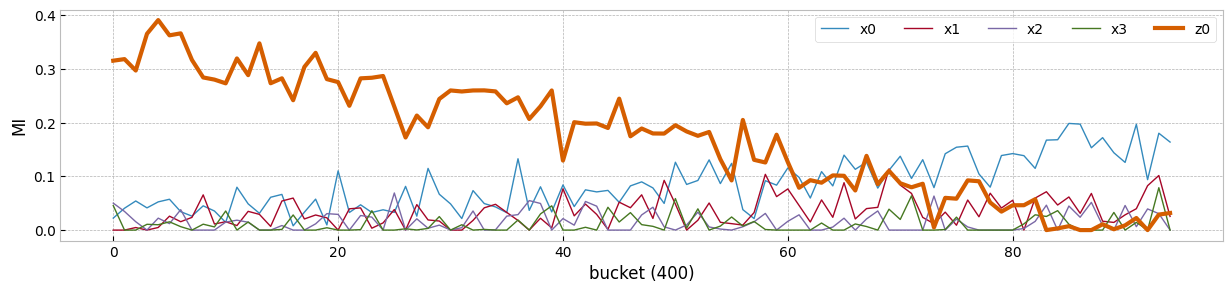

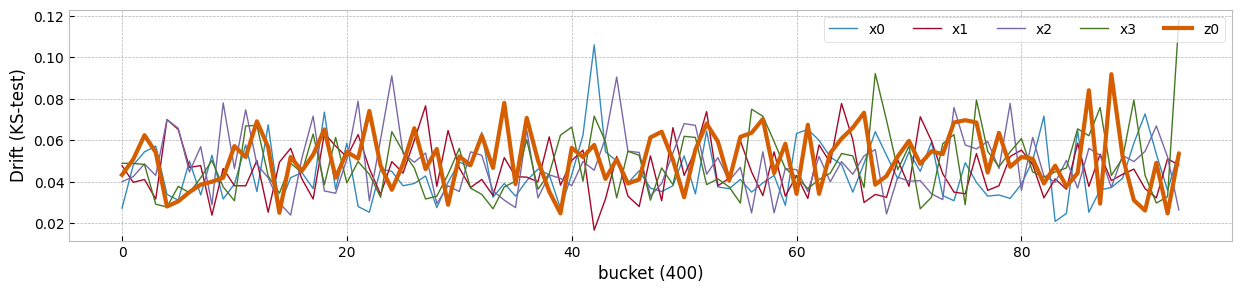

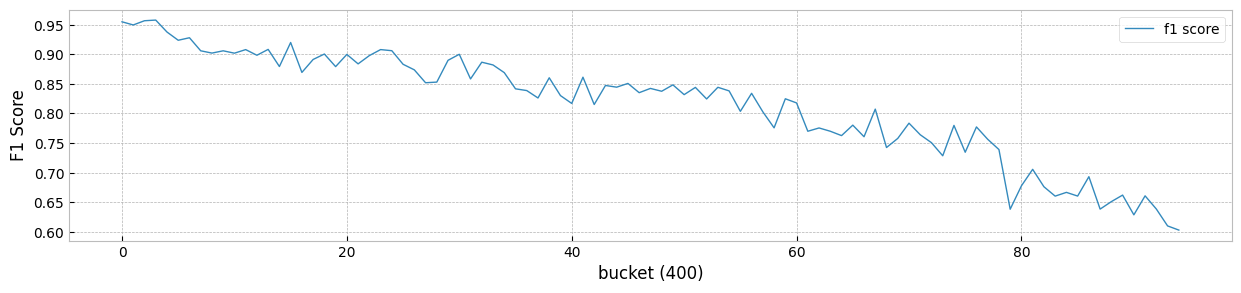

In [46]:
scaler_c2 = StandardScaler()
scaler_c2.fit(X1[0:1800])
X1 = pd.DataFrame(scaler_c2.transform(X1), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X1[0:1800], y1[0:1800])

MI_Drift_F1(model, X1,y1,1800,200,400)

#### 실험 #2
+ train:test = 2000:2000

feature 5, test_f1 0.9144518272425249


100%|██████████| 90/90 [16:03<00:00, 10.71s/it]


Total dT : 16 : 3
R2 for accuracy :  -0.9131196011849874


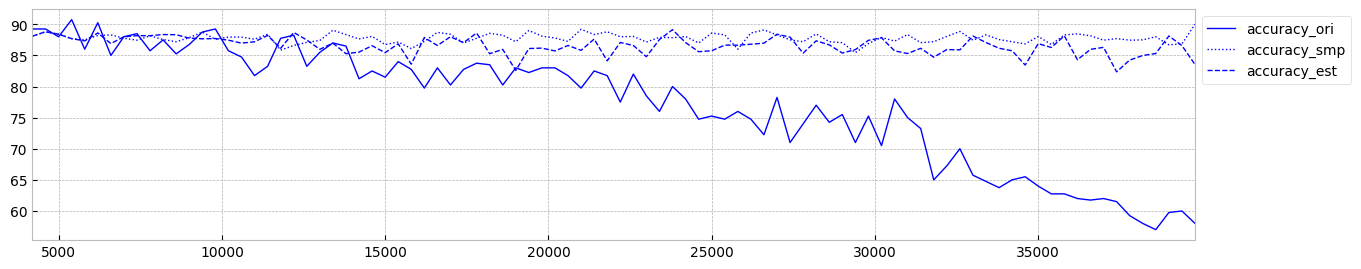

R2 for f1 :  -0.9872873095438786


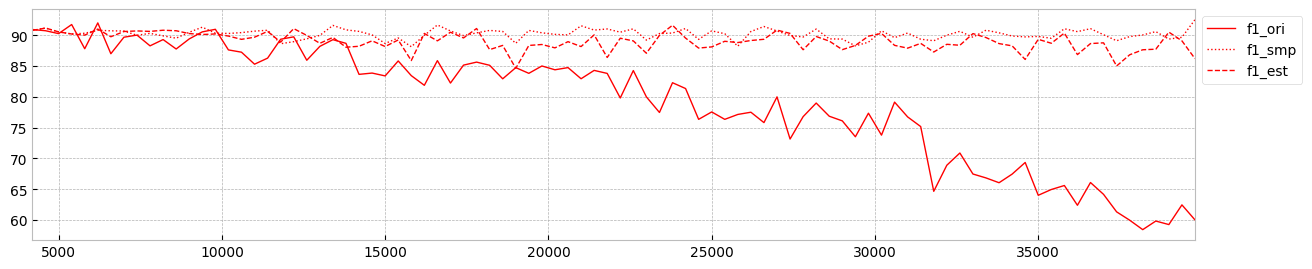

In [47]:
X1['Y'] = y1

bucket_size=400

df_train = X1[0:2000]
df_test = X1[2000:4000]
ylabel = "Y"
live_set = [X1[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X1[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols].values)
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,50)

#### 실험 #3
+ train:test = 2000:2000 (random)

feature 5, test_f1 0.9207797594359187


100%|██████████| 90/90 [15:19<00:00, 10.21s/it]


Total dT : 15 : 19
R2 for accuracy :  -1.2800472782229666


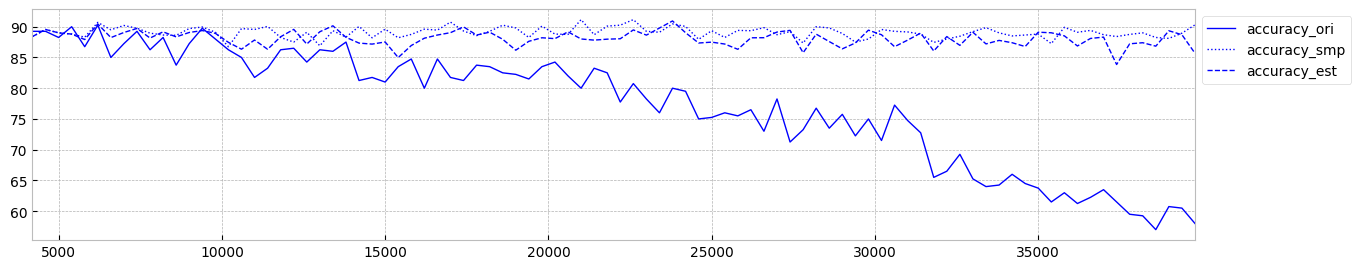

R2 for f1 :  -1.2960906523902076


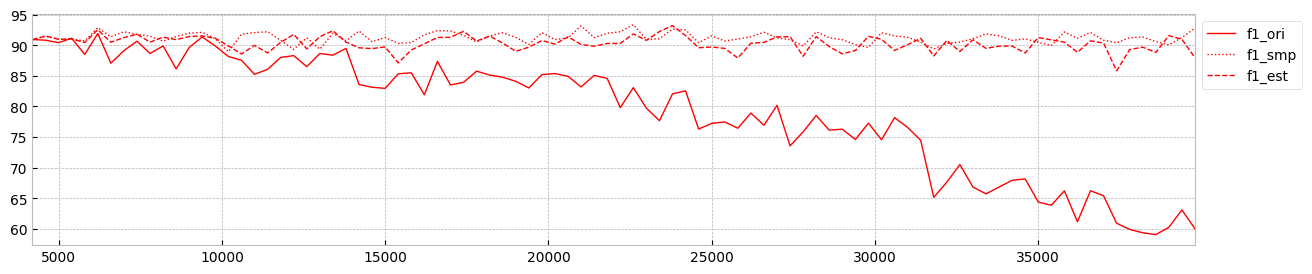

In [48]:
X1['Y'] = y1

bucket_size=400

df_train, df_test, y_train, y_test = train_test_split(X1[0:4000], y1[0:4000], test_size=0.5,random_state=777)
ylabel = "Y"
live_set = [X1[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X1[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols].values)
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,50)

#### Case #2 결론
+ real concept drift에 해당.
+ 이 Case는 어쩔 수 없음.

### Case #3 MI의 증감(상대적), Drift의 증가

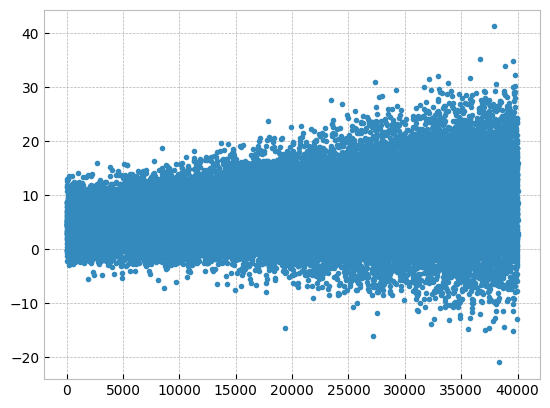

In [65]:
seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

plt.plot(y2_array,'.')

In [66]:
m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

7.2404412558678075
z0    0.269203
x0    0.077964
x1    0.028502
x2    0.012955
x3    0.001920
Name: MI Scores, dtype: float64


Bucket size 400 step_size 95


100%|██████████| 95/95 [00:07<00:00, 13.41it/s]


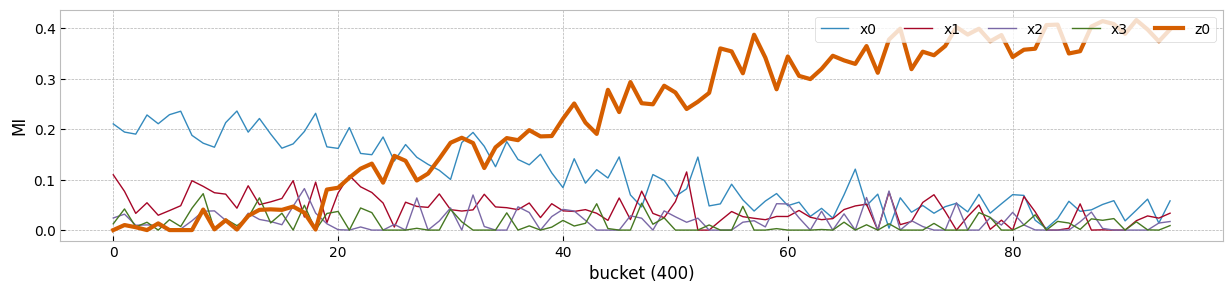

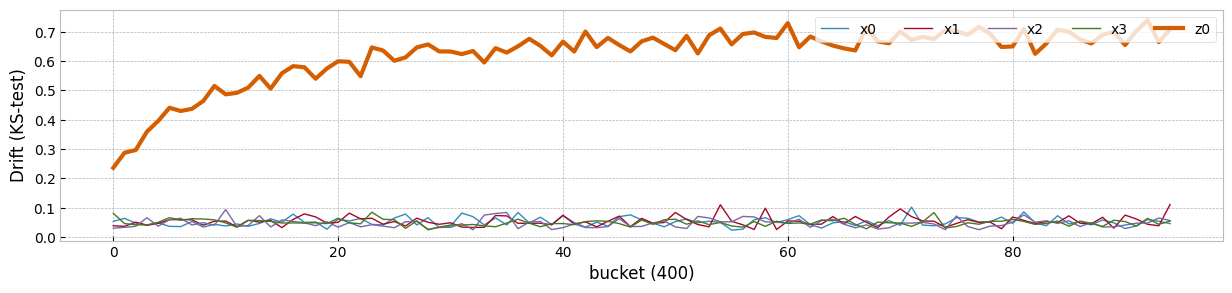

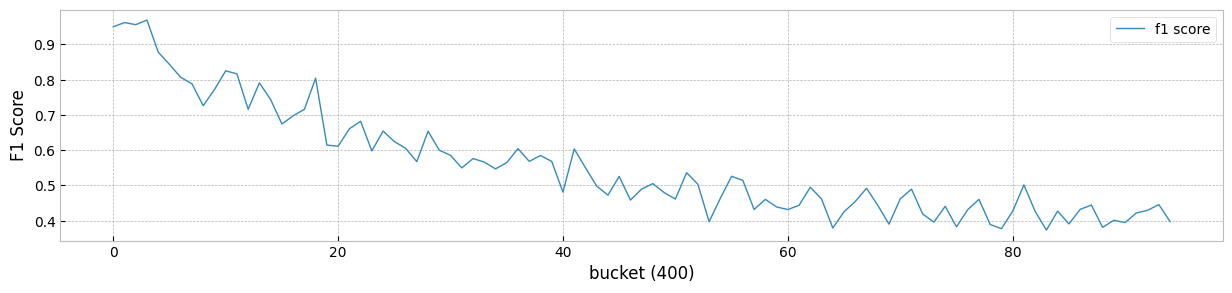

In [67]:

scaler_c3 = StandardScaler()
scaler_c3.fit(X2[0:1800])
X2 = pd.DataFrame(scaler_c3.transform(X2), columns=columns)

model = RandomForestClassifier(max_depth=6).fit(X2[0:1800], y2[0:1800])

MI_Drift_F1(model, X2,y2,1800,200,400)

#### 실험 #1
+ train:test = 1800:200

feature 5, test_f1 0.7671232876712328


100%|██████████| 95/95 [15:25<00:00,  9.74s/it]


Total dT : 15 : 25
R2 for accuracy :  -0.8120475883066471


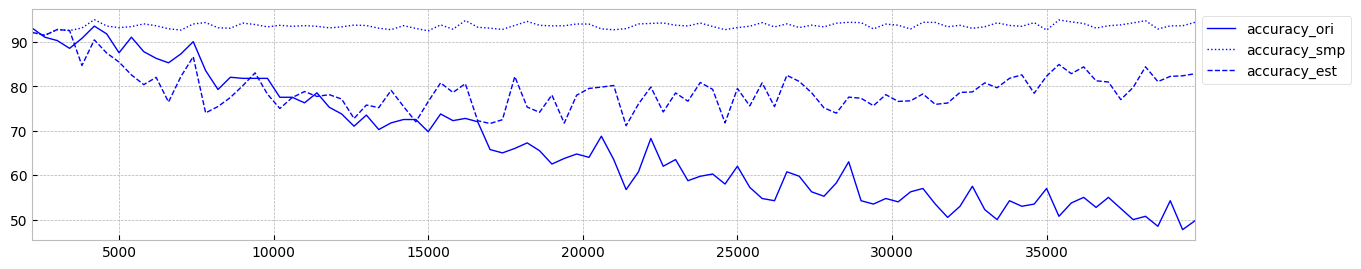

R2 for f1 :  -3.8295023411803903


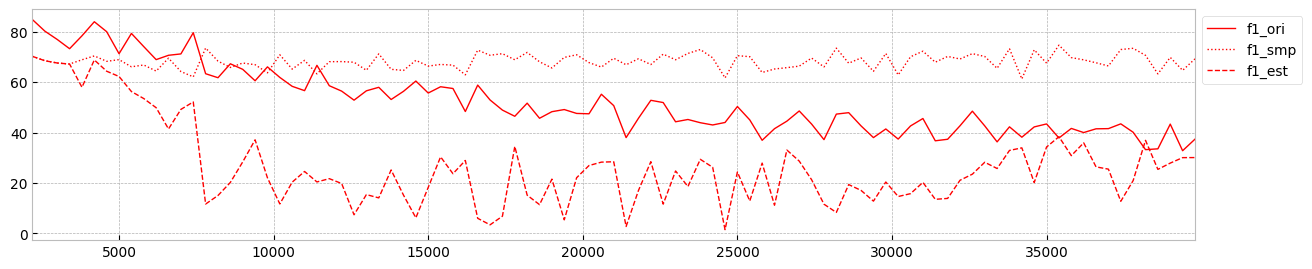

In [70]:
X2['Y'] = y2

bucket_size=400

df_train = X2[0:1800]
df_test = X2[1800:2000]
ylabel = "Y"
live_set = [X2[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X2[2000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols].values)
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,100)

#### 실험 #2
+ train:test = 2000:2000

feature 5, test_f1 0.8022727272727272


100%|██████████| 90/90 [21:31<00:00, 14.35s/it]


Total dT : 21 : 31
R2 for accuracy :  -1.9829694272358473


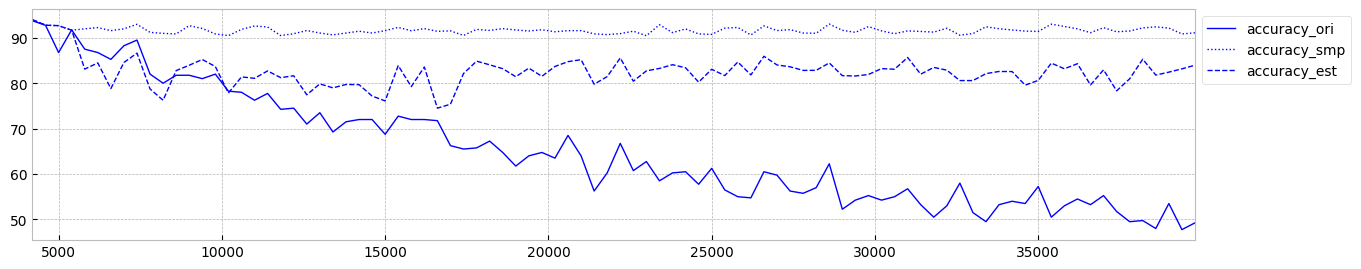

R2 for f1 :  0.11491247472180766


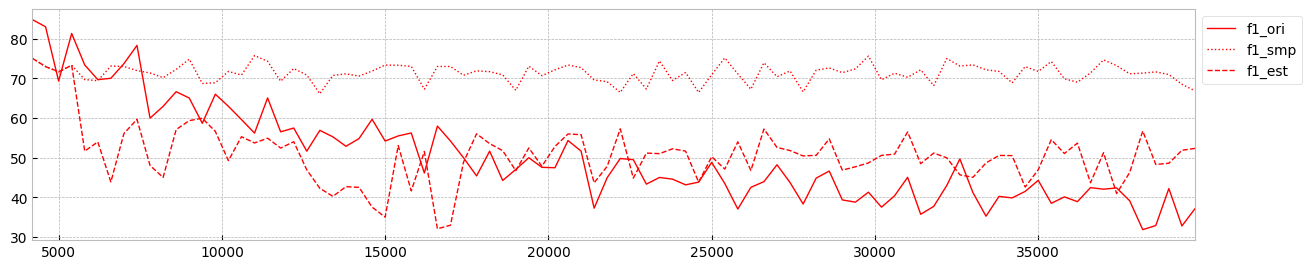

In [71]:
X2['Y'] = y2

bucket_size=400

df_train = X2[0:2000]
df_test = X2[2000:4000]
ylabel = "Y"
live_set = [X2[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X2[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols].values)
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,100)

#### 실험 #3
+ train:test = 2000:2000 (random)

feature 5, test_f1 0.874698795180723


100%|██████████| 90/90 [22:05<00:00, 14.73s/it]


Total dT : 22 : 5
R2 for accuracy :  -0.4279032027552305


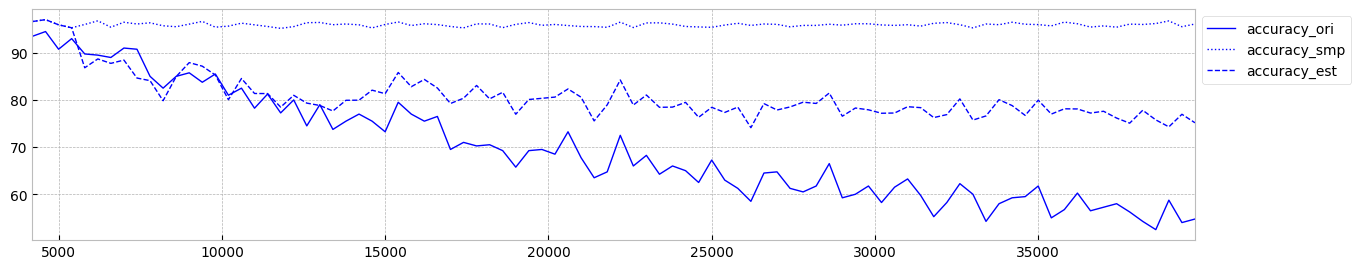

R2 for f1 :  -4.905915664646211


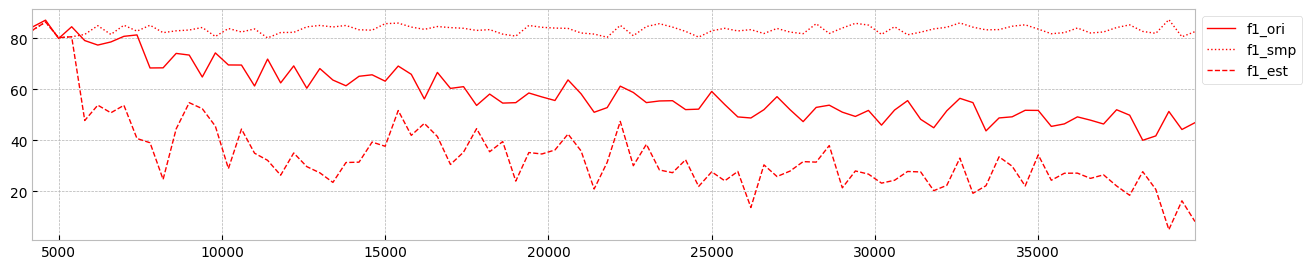

In [72]:
X2['Y'] = y2

bucket_size=400

df_train, df_test, y_train, y_test = train_test_split(X2[0:4000], y2[0:4000], test_size=0.5,random_state=777)
ylabel = "Y"
live_set = [X2[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X2[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols].values)
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,100)

#### 실험 #4
+ train:test = 2000:2000 (random)
+ bucket size, 800 으로, 400 개씩 shift 하게 liveset 구성

feature 5, test_f1 0.8694610778443114


100%|██████████| 90/90 [27:27<00:00, 18.31s/it]


Total dT : 27 : 27
R2 for accuracy :  -1.2278208872706209


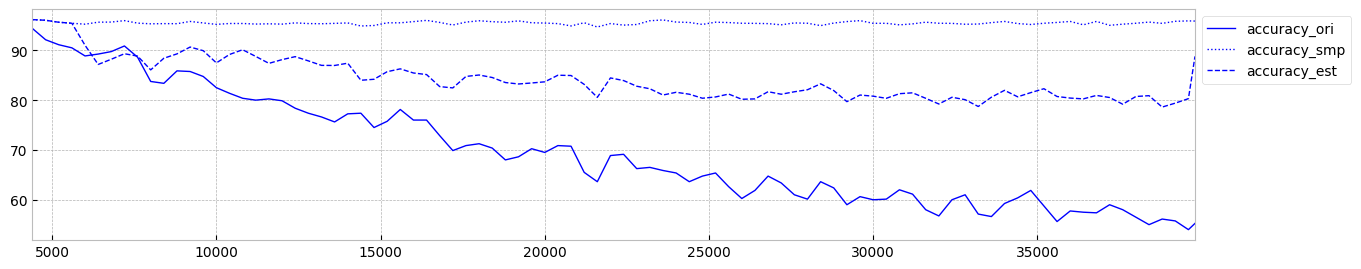

R2 for f1 :  -0.2026883875343557


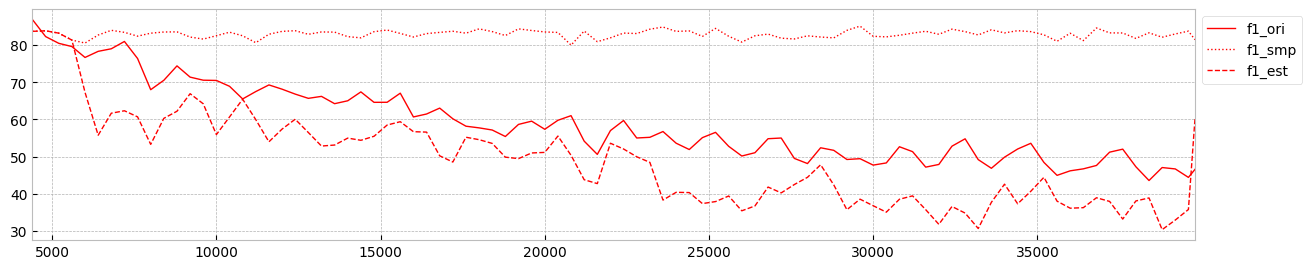

In [73]:
X2['Y'] = y2

bucket_size=(800,400)

df_train, df_test, y_train, y_test = train_test_split(X2[0:4000], y2[0:4000], test_size=0.5,random_state=777)
ylabel = "Y"
live_set = [X2[i*bucket_size[1]+4000:i*bucket_size[1]+bucket_size[0] +4000] for i in range(int(X2[4000:].shape[0]/bucket_size[1]))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols].values)
predicted_y = model.predict(df_test[target_cols])
f1_ = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1_)
DB, metrics = PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols,100)

#### Case #3 결론
+ 흠... 실험4는 어느 정도 나와 줘야 함.
+ 실험 & 알고리즘 자체 포함 원인 분석 필요.
+ 어쨋든 개선 필요.

### Real-world data(Loan data)의 실험

#### 준비

In [ ]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values


In [ ]:

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

#### MI Top 5 추출

In [ ]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

In [ ]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [ ]:
top_columns = list(mi_scores[1:6].index)
top_columns

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

#### 전체 Dataset 준비

In [ ]:
# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

In [ ]:
bucket_size=5000
train_size = X[2010].shape[0]
scaler_c6 = StandardScaler()
scaler_c6.fit(X2[0:train_size])
X2 = pd.DataFrame(scaler_c6.transform(X2), columns=top_columns)

model = RandomForestClassifier(max_depth=6).fit(X1[0:1800], y1[0:1800])

MI_Drift_F1(model, X2,Y2,int(train_size*0.9),int(train_size*0.1),bucket_size)

# VAE에 의한 Test data의 생성 적용 실험

## VAE 준비
+ 참고 : Data Augmentation for tabular data (https://colab.research.google.com/github/lschmiddey/fastpages_/blob/master/_notebooks/2021-03-14-tabular-data-variational-autoencoder.ipynb)
+ VAE 참고 : https://process-mining.tistory.com/161

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [56]:
def load_and_standardize_data(data):
    # read in from csv
    df = data #pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    X_train = df.values.reshape(-1, df.shape[1]).astype('float32')
    # randomly split
    #X_train = df #, X_test = train_test_split(df, test_size=0.0, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    return X_train, scaler #, X_test #, scaler

from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, df, train=True):
        self.X_train, self.standardizer  = load_and_standardize_data(df) #, self.standardizer = load_and_standardize_data(df)
        self.x = torch.from_numpy(self.X_train)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index]
    def __len__(self):
        return self.len

class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):

        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        #return self.lin_bn6(self.linear6(lin5))
        return self.linear6(lin5)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

## Data loading
+ Case #3 의 Data 사용.

In [57]:
traindata_set=DataBuilder(X2[0:2000], train=True)
testdata_set=DataBuilder(X2[2000:4000], train=True)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

## Train Model

In [58]:
seed_everything()

D_in = trainloader.dataset.x.shape[1]
H = D_in*40
H2 = int(H/2)
latent_dim = 2
gen_model = Autoencoder(D_in, H, H2,latent_dim).to(device)
optimizer = optim.Adam(gen_model.parameters(), lr=1e-3)
loss_mse = customLoss()

In [59]:
epochs = 400
log_interval = 50
val_losses = []
train_losses = []
test_losses = []

In [60]:
def train(epoch):
    gen_model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        #b = torch.tensor(int(batch_idx/100)/400,dtype=torch.float32).to(device)
        recon_batch, mu, logvar = gen_model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 200 == 0:
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            #b = torch.tensor((int(batch_idx+1800)/100)/400,dtype=torch.float32).to(device)
            recon_batch, mu, logvar = gen_model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            if epoch % 200 == 0:
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [61]:
seed_everything()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

====> Epoch: 200 Average training loss: 5.3599
====> Epoch: 200 Average test loss: 2.6785
====> Epoch: 200 Average test loss: 5.4608
====> Epoch: 400 Average training loss: 5.0847
====> Epoch: 400 Average test loss: 2.5880
====> Epoch: 400 Average test loss: 5.2077


In [62]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = gen_model(data)

scaler = trainloader.dataset.standardizer
recon_row = scaler.inverse_transform(recon_batch.cpu().data.numpy())

recon_row = pd.DataFrame(recon_row, columns = ['x0','x1','x2','x3','z0','y'])
recon_row

,x0,x1,x2,x3,z0,y
0,0.570414,1.255031,0.832039,0.556107,1.565021,-0.000093
1,0.444327,0.805517,0.928510,1.042124,1.148998,-0.003971
2,0.481689,0.820081,0.862162,0.927193,1.286653,0.009244
3,0.519809,0.452512,1.055206,1.299689,1.012726,-0.007094
4,0.438659,0.668004,0.944615,1.164398,1.071092,-0.021101
...,...,...,...,...,...,...
971,0.564840,1.026575,0.812115,0.703184,1.430777,0.000233
972,0.896278,1.500814,0.880861,0.540855,1.612898,0.181717
973,2.588161,1.753465,1.406593,1.269843,1.320926,0.979472
974,2.543479,1.829667,1.390480,1.152035,1.343455,0.948838


In [63]:
def generate_tabular_data(gen_model,scaler,live_data,no_samples=2000):
    gen_model.eval()
    live_data = torch.tensor(live_data).to(device)
    recon_batch, mu, logvar = gen_model(data)
    sigma = torch.exp(logvar/2)
    q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
    z = q.rsample(sample_shape=torch.Size([no_samples]))
    with torch.no_grad():
        fake_data = gen_model.decode(z).cpu().numpy()
    fake_data = scaler.inverse_transform(fake_data)

    return fake_data